# [DRAFT] Large-Scale Linear Gaussian Dynamical System 

This notebook does not perform any becnhmark and simply runs the inference procedure and generates some nice plots for the thesis.

Note: This notebook is a draft, the real experiments are in the `notebooks/` folder

_Author: Dmitry Bagaev_

In [1]:
using DrWatson

In [2]:
@quickactivate "RxInferThesisExperiments"

In [3]:
using RxInferThesisExperiments, Turing, StaticArrays, Plots, PGFPlotsX, LaTeXStrings, ReverseDiff
using LinearAlgebra, StableRNGs, Random, BenchmarkTools, ColorSchemes, Dates, ProgressMeter

[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]
[ Info: Precompiling ReverseDiff [37e2e3b7-166d-5795-8a7a-e32c996b4267]
[ Info: Precompiling LogDensityProblemsADReverseDiffExt [67aa03d1-b9b1-5e7a-8ca1-ef352975cc8e]
[ Info: Precompiling LogDensityProblemsADForwardDiffBenchmarkToolsExt [501e9729-9453-5dfd-bf52-aa40e3634be9]


In [4]:
# For the thesis I use the `pgfplotsx` backend of the `Plots`, since it generates high-quiality plots
# But it is reallyyy slow, if some wants to generate plots faster uncoment the `gr()` line
# pgfplotsx()

# Use fast plotting backend
gr()

Plots.GRBackend()

In [5]:
const environment = RotatingTracking()

RotatingTracking(2, [0.9899098464280522 0.14169860953724994; -0.14169860953724994 0.9899098464280522], [1.9 0.0; 0.0 2.0], [2.0 0.0; 0.0 2.0], [2.0 0.0; 0.0 2.0])

In [6]:
# Include the model specification
include(srcdir("models", "turing", "rotating.jl"));

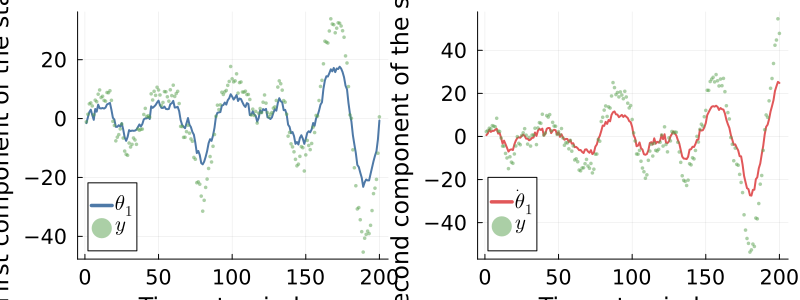

In [9]:
# For plotting purposes I only generate 250 points
T = 200
seed = 43
rng = StableRNG(seed)

states, observations = rand(rng, environment, T);

# `plotting`range
prange = firstindex(states):lastindex(states)
colors = ColorSchemes.tableau_10

# Some default settings for plotting
pfontsettings = (
    titlefontsize=18,
    guidefontsize=16,
    tickfontsize=14,
    legendfontsize=14,
    legend = :bottomleft,
    size = (400, 300)
)

p1 = plot(xlabel = "Time step index", ylabel = "First component of the state"; pfontsettings...)
p1 = plot!(prange, getindex.(states, 1)[prange], color = colors[1], linewidth = 2, label = L"\theta_1")
p1 = scatter!(p1, prange, getindex.(observations, 1)[prange], ms = 2, msw = 0, color = colors[5], alpha = 0.5, label = L"y")

p2 = plot(xlabel = "Time step index", ylabel = "Second component of the state"; pfontsettings...)
p2 = plot!(p2, prange, getindex.(states, 2)[prange], color = colors[3], linewidth = 2, label = L"\dot{\theta}_1")
p2 = scatter!(p2, prange, getindex.(observations, 2)[prange], ms = 2, msw = 0, color = colors[5], alpha = 0.5, label = L"y")

plot(p1, p2, layout = @layout([ a b ]), size = (800, 300))

In [10]:
tgmodel = rotating(observations, environment.A, environment.B, environment.P, environment.Q) 

DynamicPPL.Model{typeof(rotating), (:y, :A, :B, :P, :Q, Symbol("##arg#449")), (Symbol("##arg#449"),), (), Tuple{Vector{Vector{Float64}}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, DataType}, Tuple{DataType}, DynamicPPL.DefaultContext}(rotating, (y = [[-1.1087235277370353, 2.2449975132703908], [1.4669169914859475, 2.757346555505915], [4.990793215461305, 3.835785683182858], [5.323662139093026, 3.5091434731883586], [4.29430902692033, 5.0249858503409754], [1.2685208629109266, 4.770097529015031], [6.252900886959532, 4.515997099893177], [5.736994943873753, 8.448179813201007], [8.277067118014713, 2.523073541755009], [9.712117394623338, 2.29903796450454]  …  [-39.35198727877404, 9.984761110070815], [-38.23814839391878, 8.885970867572398], [-39.065036475005456, 16.537876168784546], [-36.26086121982937, 22.37123121306018], [-31.246984662894302, 26.907257444806564], [-25.49428514679885, 33.881639797847846], [-23.641051973573745, 42.35509167649593], [-20.66391418225984, 44

In [24]:
?ADVI()

```julia
struct ADVI{AD} <: AdvancedVI.VariationalInference{AD}
```

Automatic Differentiation Variational Inference (ADVI) with automatic differentiation backend `AD`.

# Fields

  * `samples_per_step::Int64`: Number of samples used to estimate the ELBO in each optimization step.
  * `max_iters::Int64`: Maximum number of gradient steps.


In [25]:
results = vi(tgmodel, ADVI(10, 1000));

┌ Info: [ADVI] Should only be seen once: optimizer created for θ
└   objectid(θ) = 0xde14988fe554e7c0
[ADVI] Optimizing... 100% Time: 0:00:52


In [26]:
_, sym2range = bijector(tgmodel, Val(true));
sym2range

(x = UnitRange{Int64}[1:2, 3:4, 5:6, 7:8, 9:10, 11:12, 13:14, 15:16, 17:18, 19:20  …  381:382, 383:384, 385:386, 387:388, 389:390, 391:392, 393:394, 395:396, 397:398, 399:400],)

In [27]:
import RxInfer: MvNormalMeanCovariance

In [28]:
z = rand(results, 10_000);
means = vec(mean(z; dims=2))
vars = vec(var(z; dims=2))

posteriors = []
for range in sym2range[:x]
    push!(posteriors, MvNormalMeanCovariance(means[range], Matrix(Diagonal(vars[range]))))
end

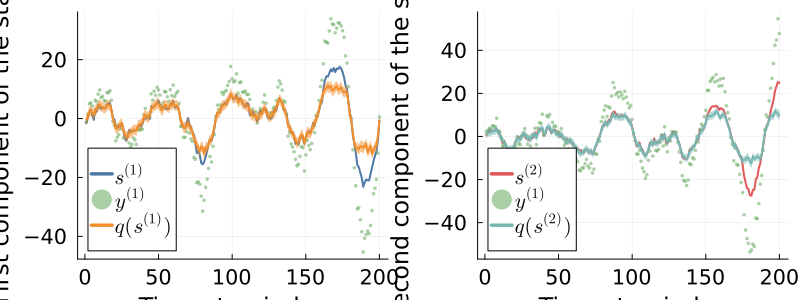

In [29]:
em = mean.(posteriors)
ev = sqrt.(cov.(posteriors))
p1 = plot(xlabel = "Time step index", ylabel = "Angle (radians)"; pfontsettings...)

p1 = plot(xlabel = "Time step index", ylabel = "First component of the state"; pfontsettings...)
p1 = plot!(p1, prange, getindex.(states, 1)[prange], color = colors[1], linewidth = 2, label = L"s^{(1)}")
p1 = scatter!(p1, prange, getindex.(observations, 1)[prange], ms = 2, msw = 0, color = colors[5], alpha = 0.5, label = L"y^{(1)}")
p1 = plot!(p1, prange, getindex.(em, 1)[prange], ribbon = 3getindex.(ev, 1, 1), color = colors[2], linewidth = 2, label = L"q(s^{(1)})")

p2 = plot(xlabel = "Time step index", ylabel = "Second component of the state"; pfontsettings...)
p2 = plot!(p2, prange, getindex.(states, 2)[prange], color = colors[3], linewidth = 2, label = L"s^{(2)}")
p2 = scatter!(p2, prange, getindex.(observations, 2)[prange], ms = 2, msw = 0, color = colors[5], alpha = 0.5, label = L"y^{(1)}")
p2 = plot!(p2, prange, getindex.(em, 2)[prange], ribbon = 3getindex.(ev, 2, 2), color = colors[4], linewidth = 2, label = L"q(s^{(2)})")

plot(p1, p2, size = (800, 300), layout = @layout([ a b ]))